In [ ]:
!pip install poliastro[jupyter] networkx scikit-learn tqdm

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

2

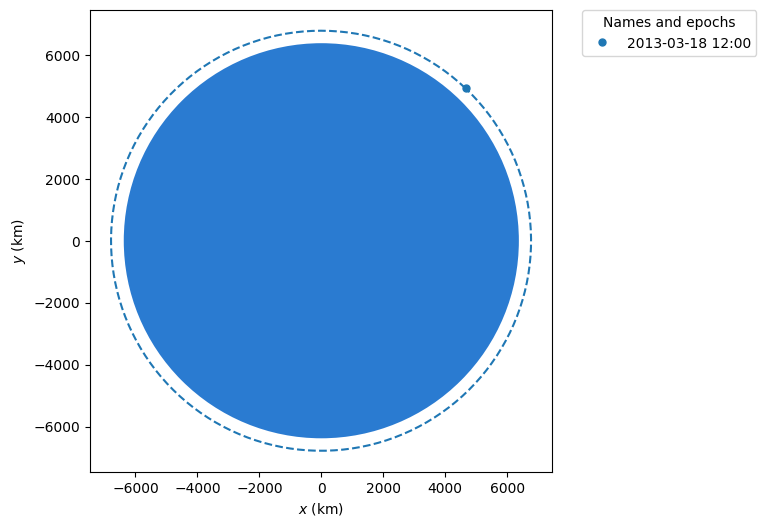

In [ ]:
from poliastro.examples import iss
iss.plot()

In [ ]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [321]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from poliastro.bodies import Earth, Mars, Mercury, Venus, Sun, Moon, Body
from poliastro.twobody import Orbit
from poliastro.ephem import Ephem
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D
from poliastro.spacecraft import Spacecraft
from poliastro.maneuver import Maneuver
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.plotting.misc import plot_solar_system
from astropy.visualization import quantity_support, time_support
quantity_support()
time_support()

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x7e7d4081ffd0>

In [ ]:
display(repr(Earth))
display(Earth.parent)
display(Earth.k)
display(Earth.R)
display(Earth.R_mean)
display(Earth.R_polar)
display(Earth.rotational_period)
display(Earth.J2)
display(Earth.J3)

'Earth (♁)'

Sun (☉)

<Quantity 3.98600442e+14 m3 / s2>

<Quantity 6378136.6 m>

<Quantity 6371008.4 m>

<Quantity 6356751.9 m>

<Quantity 0.9972698 d>

<Quantity 0.00108263>

<Quantity -2.53266132e-06>

testing stuff out

In [ ]:
sim_begin = Time('2028-01-01 00:00', scale='tdb')
sim_end = Time('2032-01-01 00:00', scale='tdb')

orb_mercury = Orbit.from_ephem(Sun, Ephem.from_body(Mercury, sim_begin), sim_begin)
orb_venus = Orbit.from_ephem(Sun, Ephem.from_body(Venus, sim_begin), sim_begin)
orb_earth = Orbit.from_ephem(Sun, Ephem.from_body(Earth, sim_begin), sim_begin)
orb_mars = Orbit.from_ephem(Sun, Ephem.from_body(Mars, sim_begin), sim_begin)


# mass based roughly on starlink sattelites
# htmq_node = Body.from_parameters(
#     parent=Sun,
#     k=Earth.k,
#     name="HTMQ Node",
#     symbol="H",
#     R=(Earth.R + Mars.R) / 2,
#     mass=1760 * u.kilogram,
# )

display(orb_earth)
display(orb_mars)

from astropy.coordinates import HeliocentricMeanEcliptic, SphericalDifferential, CartesianRepresentation
def create_node_pos(lon):
  return HeliocentricMeanEcliptic(
    lat=0*u.deg,
    lon=lon,
    distance=1.25 * u.AU,
    pm_lon=0.71*u.deg / u.day,
    pm_lat=0*u.deg / u.second,
    radial_velocity=1*u.meter / u.second,
    differential_type=SphericalDifferential,
    obstime=sim_begin,
  )

node_1_pos = create_node_pos(0*u.deg)
orb_node_1 = Orbit.from_coords(Sun, node_1_pos)
display(orb_node_1)

display(orb_earth.propagate(sim_begin).represent_as(CartesianRepresentation))

op = OrbitPlotter3D()
op.plot(orb_mercury, label="Mercury")
op.plot(orb_venus, label="Venus")
op.plot(orb_earth, label="Earth")
op.plot(orb_mars, label="Mars")
op.plot(orb_node_1, label="Node 1")
op.show()

1 x 1 AU x 23.4 deg (HCRS) orbit around Sun (☉) at epoch 2028-01-01 00:00:00.000 (TDB)

1 x 2 AU x 24.7 deg (HCRS) orbit around Sun (☉) at epoch 2028-01-01 00:00:00.000 (TDB)

1 x 1 AU x 23.4 deg (HCRS) orbit around Sun (☉) at epoch 2028-01-01 00:00:00.000 (TDB)

<CartesianRepresentation (x, y, z) in km
    (-24631241.65955205, 1.32591789e+08, 57483087.79461387)>

In [ ]:
def distance_cart(a: CartesianRepresentation, b: CartesianRepresentation):
  # Calculate the difference in the x, y, and z coordinates
  dx = a.x - b.x
  dy = a.y - b.y
  dz = a.z - b.z

  # Compute the Euclidean distance using Pythagorean theorem in three dimensions
  distance = np.sqrt(dx**2 + dy**2 + dz**2)

  return distance


lons = map(lambda x: x * u.deg, np.linspace(0, 360, 20))

nodes = list(map(create_node_pos, lons))
display("distance between first 2 nodes", distance_cart(nodes[0].cartesian, nodes[1].cartesian))
orbs = map(lambda node: Orbit.from_coords(Sun, node), nodes)

op = OrbitPlotter3D()
op.plot(orb_mercury, label="Mercury")
op.plot(orb_venus, label="Venus")
op.plot(orb_earth, label="Earth")
op.plot(orb_mars, label="Mars")
for i, orb in enumerate(orbs):
  op.plot(orb, label=f"Node {i}")
op.show()

'distance between first 2 nodes'

<Quantity 0.41148648 AU>

In [ ]:
def create_2_ring_layout(outer_nodes, inner_nodes, obstime=sim_begin):
  lons_outer = map(lambda x: x * u.deg, np.linspace(0, 360, outer_nodes))
  lons_inner = map(lambda x: x * u.deg, np.linspace(0, 360, inner_nodes) + (360 / inner_nodes / 2))

  outer_dist = 1.25 * u.AU
  inner_dist = 0.85 * u.AU

  def create_node_pos_outer(lon, obstime=sim_begin):
    return HeliocentricMeanEcliptic(
      lat=0*u.deg,
      lon=lon,
      distance=outer_dist,
      pm_lon=0.71*u.deg / u.day,
      pm_lat=0*u.deg / u.second,
      radial_velocity=1*u.meter / u.second,
      differential_type=SphericalDifferential,
      obstime=obstime,
    )

  def create_node_pos_inner(lon, obstime=sim_begin):
    return HeliocentricMeanEcliptic(
      lat=0*u.deg,
      lon=lon,
      distance=inner_dist,
      pm_lon=1.25*u.deg / u.day,
      pm_lat=0*u.deg / u.second,
      radial_velocity=1*u.meter / u.second,
      differential_type=SphericalDifferential,
      obstime=obstime,
    )

  nodes = list(map(create_node_pos_outer, lons_outer)) + list(map(create_node_pos_inner, lons_inner))
  orbs = list(map(lambda node: Orbit.from_coords(Sun, node), nodes))
  return orbs

orbs = create_2_ring_layout(10, 10, sim_begin)

op = OrbitPlotter2D()
op.plot(orb_mercury, label="Mercury")
op.plot(orb_venus, label="Venus")
op.plot(orb_earth, label="Earth")
op.plot(orb_mars, label="Mars")
for i, orb in enumerate(orbs):
  op.plot(orb, label=f"Node {i}", color="black")
op.show()

In [ ]:
from functools import lru_cache, reduce

def to_trajectory(positions: list[CartesianRepresentation]) -> CartesianRepresentation:
  def f(a: CartesianRepresentation, b: CartesianRepresentation):
    axyz = a.xyz.to_value(u.km)
    if axyz.shape == (3,):
      axyz = np.reshape(axyz, (3, 1))
    bxyz = b.xyz.to_value(u.km)
    if bxyz.shape == (3,):
      bxyz = np.reshape(bxyz, (3, 1))

    nums = np.append(axyz, bxyz, axis=1)
    return CartesianRepresentation(nums, unit=a.xyz.unit)
  return reduce(f, positions)

t1 = to_trajectory([CartesianRepresentation(0 * u.km, 0 * u.km, 0 * u.km), CartesianRepresentation(1 * u.km, 1 * u.km, 1 * u.km)])
display(t1)
t2 = to_trajectory([CartesianRepresentation(0, 1, 2, unit=u.km), CartesianRepresentation(1, 2, 3, unit=u.km)])
display(t2)
display(to_trajectory([t1, t2]))


<CartesianRepresentation (x, y, z) in km
    [(0., 0., 0.), (1., 1., 1.)]>

<CartesianRepresentation (x, y, z) in km
    [(0., 1., 2.), (1., 2., 3.)]>

<CartesianRepresentation (x, y, z) in km
    [(0., 0., 0.), (1., 1., 1.), (0., 1., 2.), (1., 2., 3.)]>

### Real world tests

| Test | Distance (km) | Data Rate |
|-|-|-|
| [Taters](https://www.jpl.nasa.gov/news/nasas-tech-demo-streams-first-video-from-deep-space-via-laser) | 31000000 | 267 Mbit/s |
| [Psyche](https://www.nasa.gov/missions/psyche-mission/nasas-optical-comms-demo-transmits-data-over-140-million-miles/) | 226000000 | 25 Mbit/s |
| [TBIRD](https://www.spacedaily.com/reports/Communications_system_achieves_fastest_laser_link_from_space_yet_999.html) | 482.803 | 100 Gbit/s |
| [LLCD](https://www.nasa.gov/missions/tech-demonstration/laser-communications-relay/historic-demonstration-proves-laser-communication-possible/) | 384400 | 662 Mbit/s |

In [ ]:
x = [
    # 482.803,
    384400,
    31e6,
    226e6,
]
y = [
    # 100_000,
    662e6,
    267e6,
    25e6,
]

R2 score: 0.7391996843142628
model params [-2.25895449] 511806548.85304934


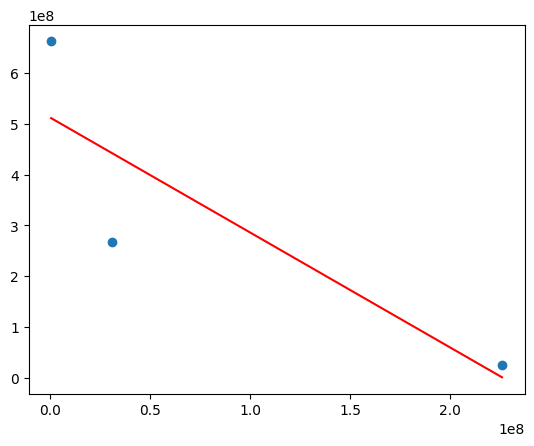

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(x).reshape(-1, 1), y)

print("R2 score:", model.score(np.array(x).reshape(-1, 1), y))
print("model params", model.coef_, model.intercept_)

import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.plot(x, model.predict(np.array(x).reshape(-1, 1)), color='red')
plt.show()


<ipython-input-267-11373d736004>:11: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning:

Covariance of the parameters could not be estimated



Optimal values for a and b: [6.45297832e+02 3.15693980e-02 2.44857121e+01]


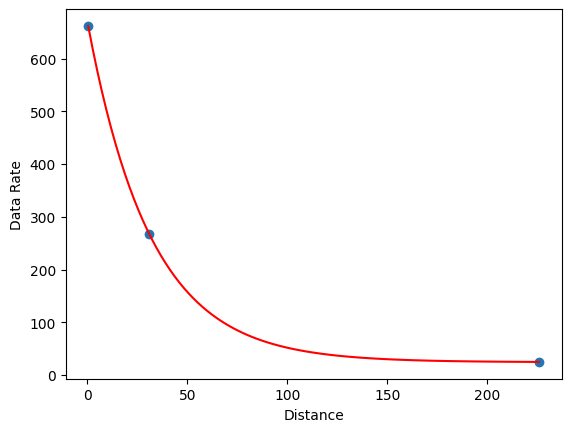

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

x = np.array(x, dtype=float) / 1e6
y = np.array(y, dtype=float) / 1e6

def func(x, a, b, c):
  return a * np.exp(b * -x) + c

popt, pcov = curve_fit(func, x, y)

print("Optimal values for a and b:", popt)

more_x = np.linspace(x.min(), x.max(), 100)
# Generate the curve using the fitted parameters
y_pred = func(more_x, *popt)

# Plot the data and the fitted curve
plt.scatter(x, y)
plt.plot(more_x, y_pred, color='red')
plt.xlabel('Distance')
plt.ylabel('Data Rate')
plt.show()


In [314]:
from functools import lru_cache, reduce
from typing import TypeVar

TNode = TypeVar("TNode", bound="Node")

class Node:
  def __init__(self, name: str, group: str, orb: Orbit):
    self.name = name
    self.group = group
    self.orb = orb

  @lru_cache(maxsize=None)
  def position(self, obstime: Time):
    return Ephem.from_orbit(self.orb, obstime).sample(obstime)

  @lru_cache(maxsize=None)
  def distance(self, other: TNode, obstime: Time):
    return distance_cart(self.position(obstime), other.position(obstime))

  def __repr__(self):
    return f"Node[{self.name}]"

earth = Node("Earth", "planet", orb_earth)
mars = Node("Mars", "planet", orb_mars)

def build_network_graph(orbs, obstime):
  nodes = [Node(f"Node {i}", "node", orb) for i, orb in enumerate(orbs)]

  graph = nx.Graph()
  graph.add_node(earth)
  graph.add_node(mars)
  graph.add_nodes_from(nodes)

  for node in graph.nodes():
    for other_node in graph.nodes():
      if node == other_node:
        continue
      distance = node.distance(other_node, obstime)
      rate = estimate_data_rate(distance)
      if rate < 100e6:
        continue
      graph.add_edge(node, other_node)

  return graph

def estimate_data_rate(distance):
  if isinstance(distance, u.Quantity):
    distance = distance.to_value(u.km)

  return func(distance / 1e6, *popt) * 1e6

def shortest_path_earth_mars(orbs, obstime):
  graph = build_network_graph(orbs, obstime)

  def heuristic(node: Node, target: Node, _=None):
    dist = node.distance(target, obstime).to_value(u.km)[0]
    rate = estimate_data_rate(dist).item()
    return 1 / rate

  path = nx.astar_path(graph, earth, mars, heuristic)
  # path = nx.dijkstra_path(graph, earth, mars, heuristic)
  return path

def distance_path(path, obstime):
  distance = 0
  for i in range(len(path) - 1):
    distance += path[i].distance(path[i + 1], obstime)
  return distance


def plot_orbs_and_path(orbs: list[Orbit], path: list[Node], obstime: Time):
  op = OrbitPlotter2D()
  op.plot_body_orbit(Mercury, obstime)
  op.plot_body_orbit(Venus, obstime)
  op.plot_body_orbit(Earth, obstime)
  op.plot_body_orbit(Mars, obstime)

  traj_direct = to_trajectory([earth.position(obstime), mars.position(obstime)])
  op.plot_trajectory(traj_direct, label="Direct path", color="red")

  traj_path = to_trajectory([node.position(obstime) for node in path])
  op.plot_trajectory(traj_path, label="Path along network", color="blue")

  assert len(orbs) > 0
  for i, orb in enumerate(tqdm(orbs)):
    op.plot_ephem(Ephem.from_orbit(orb, time_range(current - 1 * u.day, periods=3, end=current)), label=f"Node {i}", color="black")
  return op.show()

config_params = (30, 20)

def plot_orbs_and_graph(orbs: list[Orbit], graph: nx.Graph, obstime: Time):
  op = OrbitPlotter2D()
  op.plot_body_orbit(Mercury, obstime)
  op.plot_body_orbit(Venus, obstime)
  op.plot_body_orbit(Earth, obstime)
  op.plot_body_orbit(Mars, obstime)

  assert len(orbs) > 0
  for i, orb in enumerate(tqdm(orbs)):
    op.plot_ephem(Ephem.from_orbit(orb, time_range(current - 1 * u.day, periods=3, end=current)), label=f"Node {i}", color="black")

  for source, target in tqdm(graph.edges()):
    traj_direct = to_trajectory([source.position(obstime), target.position(obstime)])
    op.plot_trajectory(traj_direct, label=None, color="black")

  return op.show()

def data_rate_along_path(path, obstime):
  rates = []
  for i in range(len(path) - 1):
    distance = path[i].distance(path[i + 1], obstime)
    rate = estimate_data_rate(distance)
    rates.append(rate)
  return rates

### Visualize network connections

In [334]:
orbs = create_2_ring_layout(*config_params, obstime=sim_begin)
graph = build_network_graph(orbs, sim_begin)
plot = plot_orbs_and_graph(orbs, graph, sim_begin)
display(plot)

100%|██████████| 105/105 [02:34<00:00,  1.47s/it]


### Plot effectiveness over time

In [323]:
times = []
current = sim_begin
while current < sim_end:
  times.append(current)
  current += 7 * u.day

direct_distances = []
path_distances = []
data_rates = []

for current in tqdm(times):
  orbs = create_2_ring_layout(*config_params, obstime=current)
  path = shortest_path_earth_mars(orbs, current)

  direct_distances.append(earth.distance(mars, current))
  distance = distance_path(path, current)
  # display("Path", distance.to(u.AU))
  path_distances.append(distance)
  rates = data_rate_along_path(path, current)
  rate_avg = (sum(rates) / len(rates)).item() * u.bit/u.s
  rate_min = min(rates).item() * u.bit/u.s
  rate_max = max(rates).item() * u.bit/u.s
  # display("Data rate (avg)", rate_avg.to(u.megabit/u.s))
  # display("Data rate (min)", rate_min.to(u.megabit/u.s))
  # display("Data rate (max)", rate_max.to(u.megabit/u.s))
  data_rates.append([rate_min.to_value(u.megabit/u.s), rate_avg.to_value(u.megabit/u.s), rate_max.to_value(u.megabit/u.s)])
  # plot = plot_orbs_and_path(orbs, path, current)
  # display(plot)

100%|██████████| 209/209 [05:25<00:00,  1.56s/it]


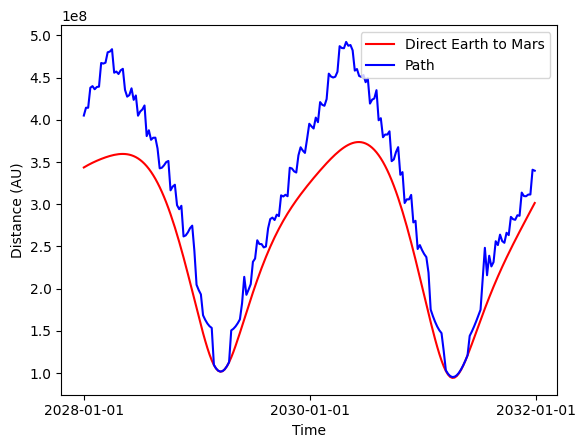

None

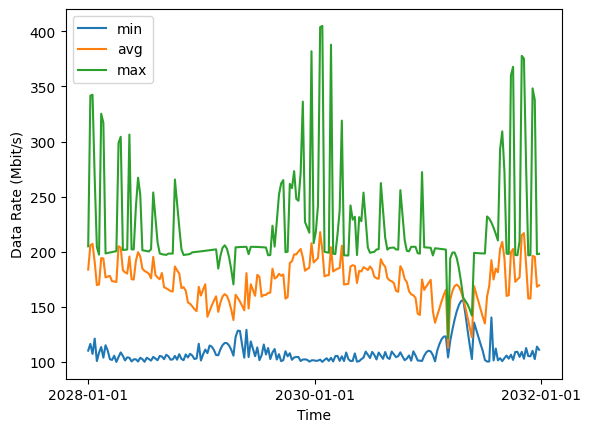

None

In [345]:
times = Time(times)
direct_distances = u.Quantity(direct_distances)
path_distances = u.Quantity(path_distances)
data_rates = data_rates * u.megabit/u.s

plt.plot(times, direct_distances, label="Direct Earth to Mars", color="red")
plt.plot(times, path_distances, label="Path", color="blue")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Distance (AU)")
display(plt.show())

rates = np.array(data_rates)
plt.plot(times, rates, label=["min", "avg", "max"])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Data Rate (Mbit/s)")
display(plt.show())